In [4]:
%%capture
%pip install tqdm
%pip install torch
%pip install matplotlib
%pip install sklearn
%pip install seaborn
%pip install torchvision
%pip install utils
%pip install numpy
%pip install torchsummary
%pip install ipywidgets

In [5]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Import EuroSAT_data class from EuroSAT module
from EuroSAT import EuroSAT_data

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
# input size of 224x224 pixels is a common convention in many pre-trained 
# deep learning models, especially those trained on ImageNet
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [7]:
# Load the dataset
data_dir = './EuroSAT_data'

# Create an instance of EuroSAT_data
dataset = EuroSAT_data(data_dir, transform=train_transform)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']
Total number of classes: 10


In [8]:
# Apply different transformations to the training and test sets
train_data = EuroSAT_data(data_dir, train_transform)
test_data = EuroSAT_data(data_dir, test_transform)

# Randomly split the dataset into 80% train / 20% test 
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(len(dataset)))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


In [9]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

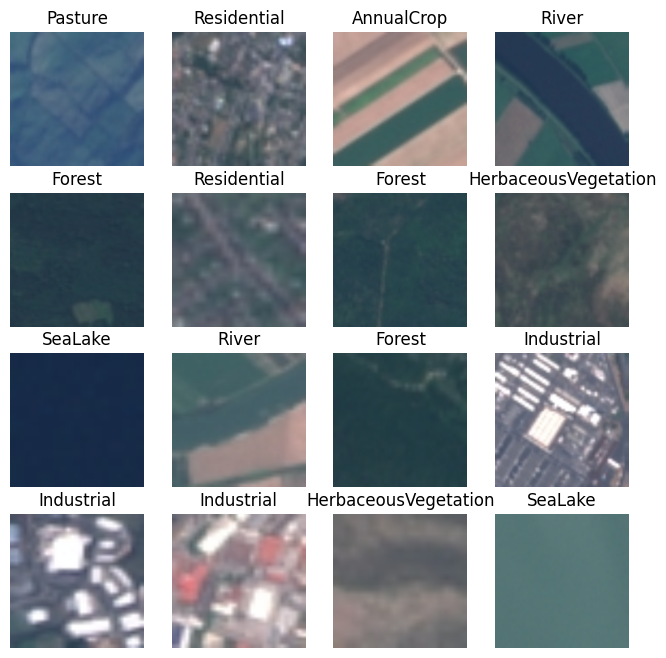

In [10]:
#visualising a 4x4 grid ofr images from all classes
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

index = 1 

for i in range(4):
    for j in range(4):
        image = inputs[i * 4 + j].numpy().transpose((1, 2, 0))
        image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
        class_name = class_names[classes[i * 4 + j]]
        axes[i, j].imshow(image)
        axes[i, j].set_title(class_name)  # Set class name as the title
        axes[i, j].axis('off')

plt.show()

In [11]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

torchsummary.summary(model, (3, 224, 224))

/Users/tanushreesudheer/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/tanushreesudheer/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
# specifying lr
lr = 1e-3 #1e-2, 1e-5

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [13]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order 
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the 
    # internally stored gradients
    optimizer.step()

    # Calculate statistics            
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [14]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels) 
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [15]:
# Keep track of the best loss and best model weights with the lowest loss
best_validation_loss = np.inf
best_model_state_dict = None

# Train and test over n_epochs
for epoch in range(5):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    validation_loss, _ = evaluate(model, test_loader, criterion)

    # Update best model if validation loss is lower
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_model_state_dict = model.state_dict()
        
#Define the directory for saving the model
model_dir = "Webapp"

# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define the file path for saving the best model
model_file_path = os.path.join(model_dir, 'best_model.pth')

# Save the best model
torch.save(best_model_state_dict, model_file_path)
print('Best model successfully saved to {}'.format(model_file_path))
        


Epoch 1


  0%|          | 0/1350 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
# Load the ResNet-50 model architecture
model = models.resnet50(pretrained=True)

# Modify the fully connected layer to match the number of output classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)  # Assuming 10 output classes

# Define the path to the saved model file
model_file = os.path.join(model_dir, 'best_model.pth')

# Load the saved model weights
model.load_state_dict(torch.load(model_file))

# Set the model to evaluation mode
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file Webapp/best_model.pth successfully loaded.


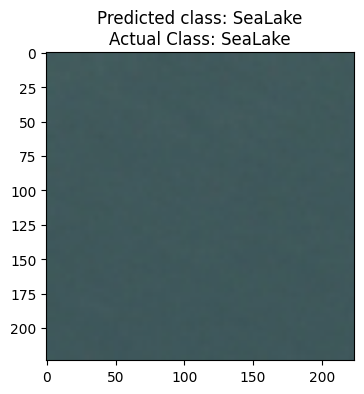

In [18]:
# Retrieve sample image
index = 10
image, label = test_data[index]

# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

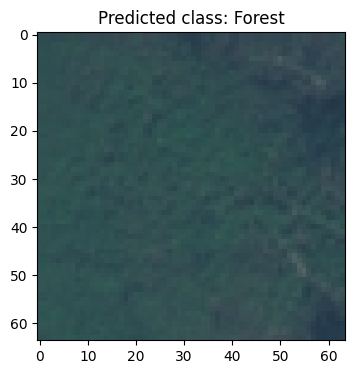

In [19]:
from PIL import Image
image_path = './EuroSAT_data/Forest/Forest_8.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));